In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
!pip install ta
import ta

# Đọc dữ liệu từ file Excel
df = pd.read_excel('/kaggle/input/fptstock/Copy of Simplize_FPT_PriceHistory_20250511.xlsx')

# Đổi tên cột cho tiện xử lý (nếu là tiếng Việt)
df = df.rename(columns={
    'NGÀY': 'Date',
    'GIÁ MỞ CỬA': 'Open',
    'GIÁ CAO NHẤT': 'High',
    'GIÁ THẤP NHẤT': 'Low',
    'GIÁ ĐÓNG CỬA': 'Close',
    'KHỐI LƯỢNG': 'Volume'
})

# Chuyển Date sang dạng datetime và sắp xếp
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Chọn các cột dùng để huấn luyện
data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# SMA và EMA
df['SMA_14'] = ta.trend.sma_indicator(df['Close'], window=14)
df['EMA_14'] = ta.trend.ema_indicator(df['Close'], window=14)

# RSI
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)

# Thay đổi giá theo phần trăm so với ngày trước đó
df['Price_Change'] = df['Close'].pct_change()

# Độ biến động (độ lệch chuẩn trong 14 ngày)
df['Volatility'] = df['Close'].rolling(window=14).std()

df.dropna(inplace=True)

# Hiển thị vài dòng đầu
data.head()

2025-05-11 12:18:09.487629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746965889.771014      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746965889.852930      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3ba8cb32e7c41e86ee2ecf043a14885898d1612a7869c1fc2562e129c617cbfa
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


,Open,High,Low,Close,Volume
Date,,,,,
2021-05-07,41891.269456,42549.777924,41688.651466,42043.232949,2750900
2021-05-10,42093.887446,43562.867874,42043.232949,43461.558879,4581300
2021-05-11,43562.867874,43866.794860,43157.631894,43157.631894,2284000
2021-05-12,43056.322899,43258.940889,42701.741416,43258.940889,1864500
2021-05-13,43056.322899,43258.940889,42549.777924,42549.777924,2789200


In [11]:
# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Tạo dữ liệu chuỗi thời gian
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, df.columns.get_loc('Close')])  # vị trí của cột Close
    return np.array(X), np.array(y)

# Sử dụng 60 ngày để dự đoán ngày tiếp theo
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Kiểm tra hình dạng đầu vào
print("X shape:", X.shape)  # (samples, timesteps, features)
print("y shape:", y.shape)

X shape: (940, 60, 5)
y shape: (940,)


In [10]:
# 80% dữ liệu dùng để train, còn lại để test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 0.0363 - val_loss: 0.0028
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/ste

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


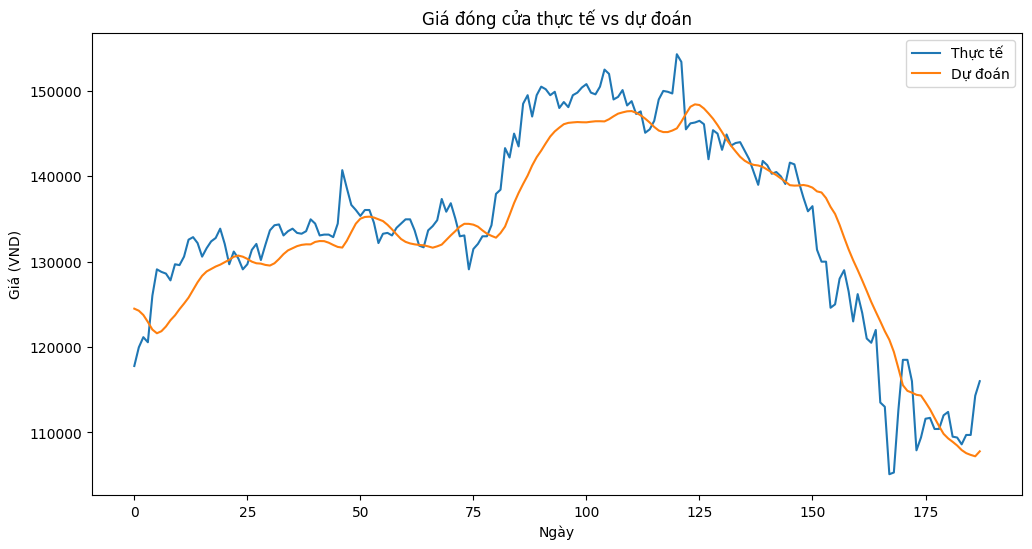

In [14]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chỉ scale lại giá đóng cửa (cột thứ 4)
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]

# Scale ngược lại
y_test_inv = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = close_scaler.inverse_transform(y_pred)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Thực tế')
plt.plot(y_pred_inv, label='Dự đoán')
plt.legend()
plt.title('Giá đóng cửa thực tế vs dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá (VND)')
plt.show()

In [16]:
# Sử dụng đúng biến và đảm bảo kích thước đầu vào khớp với mô hình
last_sequence = scaled_data[-sequence_length:]
input_seq = last_sequence.reshape(1, sequence_length, X.shape[2])

In [17]:
future_predictions = []
num_days = 756  # ~3 năm (252 ngày/năm)

for _ in range(num_days):
    pred = model.predict(input_seq)[0][0]
    future_predictions.append(pred)

    # Tạo chuỗi mới bằng cách dịch dữ liệu và thêm giá trị dự đoán
    next_input = np.append(input_seq[0, 1:, :], [[0, 0, 0, pred, 0]], axis=0)
    input_seq = next_input.reshape(1, sequence_length, data.shape[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [18]:
# Biến đổi giá Close từ [0, 1] về giá thực tế
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
predicted_close = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

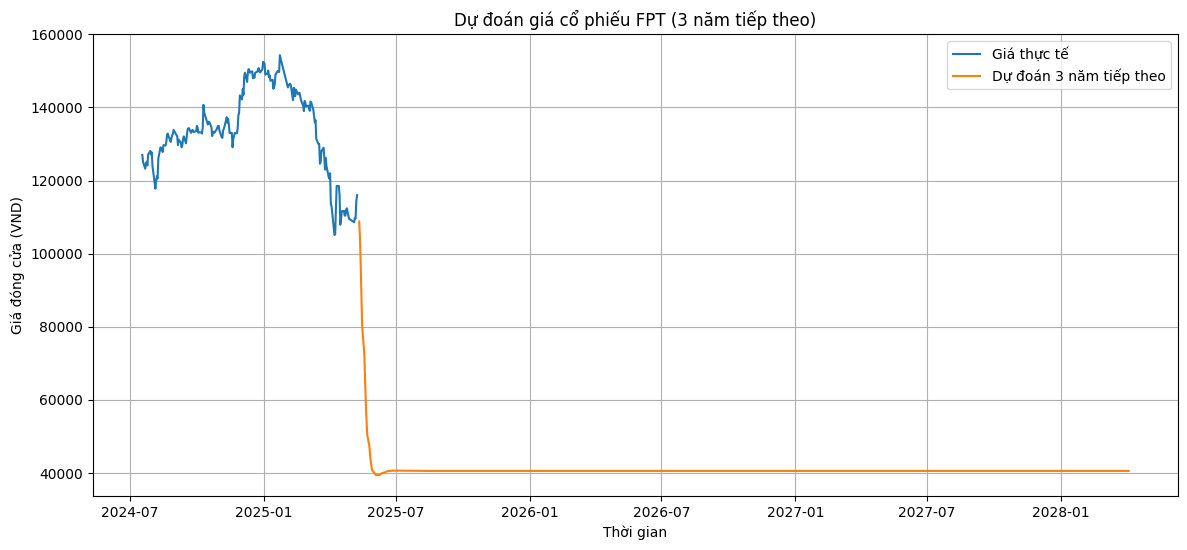

In [22]:
# Tạo dãy ngày tương lai
last_date = data.index[-1]
future_dates = pd.bdate_range(start=last_date, periods=num_days+1, freq='C')[1:]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Close'].values[-200:], label='Giá thực tế')
plt.plot(future_dates, predicted_close, label='Dự đoán 3 năm tiếp theo')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VND)')
plt.title('Dự đoán giá cổ phiếu FPT (3 năm tiếp theo)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import pandas as pd

# Tạo DataFrame kết quả
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': predicted_close.flatten()
})

# Lưu ra file Excel
forecast_df.to_excel('/kaggle/working/fpt_3_year_forecast.xlsx', index=False)

print("✅ File dự đoán đã được lưu tại: /kaggle/working/fpt_3_year_forecast.xlsx")

✅ File dự đoán đã được lưu tại: /kaggle/working/fpt_3_year_forecast.xlsx
